2018 Oct 9<br>
Since I'm getting a little short on time for DPS, I'm going to do a quick once-through of the planned full analysis using the Levenberg-Marquardt approach, with simplified error estimates. Later, I'll go back through with the MCMC analysis to clean up uncertainty estimates.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from scipy.signal import lombscargle
from scipy.stats import normaltest, ks_2samp

from lightkurve import KeplerLightCurveFile
from PyAstronomy.modelSuite.XTran.forTrans import MandelAgolLC

from transit_utils import bindata, transit_duration, supersample_time
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import time as tm

import dill

K76 = Kepler76_params()

BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
num_period = 2
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

print((np.max(filtered_time) - np.min(filtered_time))/K76.saved_ep.per)

158.5868291130012
944.6965591847746


In [4]:
def fit_transit(time, baseline, a, T0, p, b, supersample_factor=10, exp_time=30./60./24.):
    params = K76.saved_params.copy()

    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = params['per']
    ma['a'] = a
    ma['T0'] = T0
    ma['p'] = p
    ma['i'] = np.arccos(b/a)*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

[-4.34593478e-05  5.09154703e+00  6.84990158e-01  8.48417463e-02
  9.08334336e-01]
[4.61826107e-06 5.01485167e-02 2.39761773e-05 4.94852763e-04
 2.63570537e-03]


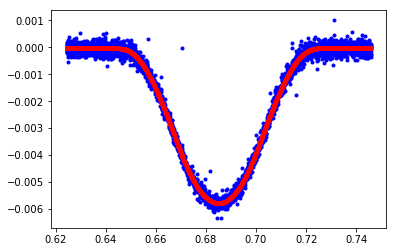

In [5]:
# Fit folded transit
bounds = ([-1000e-6, 2., K76.saved_params['T0']*0.95, 0., -1],
          [1000e-6, 10., K76.saved_params['T0']*1.05, 0.2, 1])

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., K76.saved_params['a'], K76.saved_params['T0'], K76.saved_params['p'], K76.saved_params['b']]
transit_popt, transit_pcov = curve_fit(fit_transit, time, data, sigma=err, p0=initial_guess, bounds=bounds)

transit_uncertainties = np.sqrt(transit_pcov.diagonal())

print(transit_popt)
print(transit_uncertainties)

plt.plot(time, data, 'b.')
plt.plot(time, fit_transit(time, *transit_popt), 'r.')

(-0.0015778106389222864, 0.0015778106389222864)

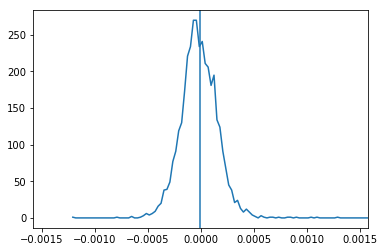

In [6]:
# 2018 Oct 19 - Checking residuals
first_resid = data - fit_transit(time, *transit_popt)

md = mad(first_resid)

hst, bin_edges = np.histogram(first_resid, bins='auto')
plt.plot(bin_edges[:-1], hst)
plt.axvline(np.median(first_resid))
plt.xlim([-10*md, 10.*md])

In [7]:
def fit_transit_midtime(time, baseline, T0, 
                        transit_params=transit_popt, supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = params['per']
    ma['a'] = transit_params[1]
    ma['T0'] = T0
    ma['p'] = transit_params[3]
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

<Container object of 3 artists>

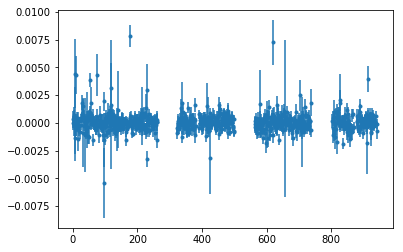

In [8]:
# Fitting transit ephemeris
mn = np.min(filtered_time)
mx = np.min(filtered_time) + K76.saved_params['per']

current_transit_num = 0
transit_nums = []
mid_transit_times = np.array([])
mid_transit_times_err = np.array([])
while(mn <= np.max(filtered_time) - K76.saved_params['per']):
#while(mn < np.min(filtered_time) + 2.*K76.saved_params['per']):
    
    ind = (filtered_time >= mn) & (filtered_time < mx)
    unfolded_time = filtered_time[ind]
    time = folded_time[ind]
    data = filtered_flux[ind]
    err = unbinned_noise*np.ones_like(time)
    
    transit_ind = transit_indices(time, 2.*K76.dur, K76.saved_params['T0'])
    # At least three points in transit
    if(time[transit_ind].size >= 3):

        bounds = ([-1000e-6, K76.saved_params['T0']*0.95],
          [1000e-6, K76.saved_params['T0']*1.05])

        initial_guess = [0., K76.saved_params['T0']]
        single_transit_popt, single_transit_pcov = curve_fit(fit_transit_midtime, time, data, sigma=err,
                                                             p0=initial_guess, bounds=bounds)
        single_transit_uncertainties = np.sqrt(single_transit_pcov.diagonal())

        if(single_transit_uncertainties[1] > 0):
            transit_nums.append(current_transit_num)
            mid_transit_times = np.append(mid_transit_times, single_transit_popt[1] +\
                                          np.floor(np.min(filtered_time[ind])/K76.saved_params['per'])*\
                                          K76.saved_params['per'])
            mid_transit_times_err = np.append(mid_transit_times_err, single_transit_uncertainties[1])
            
#             plt.plot(filtered_time[ind], data, 'b.')
#             plt.plot(filtered_time[ind], fit_transit_midtime(time, *single_transit_popt), 'r.', alpha=0.5)
#             plt.axvline(single_transit_popt[1] +\
#                         np.floor(np.min(filtered_time[ind])/K76.saved_params['per'])*K76.saved_params['per'])

    current_transit_num += 1
    mn += K76.saved_params['per']
    mx += K76.saved_params['per']
    
plt.errorbar(transit_nums, mid_transit_times - K76.saved_params['per']*np.array(transit_nums) - mid_transit_times[0], 
             mid_transit_times_err, marker='.', ls='')

1.544928932, 132.004132394
[9.07995328e-08 4.52744842e-05]
1.544928750
928.9618577335933


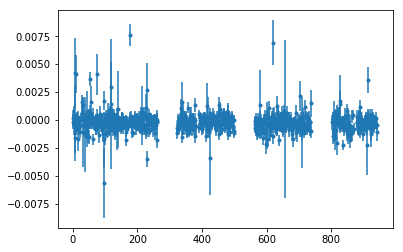

In [9]:
# Fit new period
def fit_line(x, m, b):
    return m*x + b

bounds = ([K76.saved_params['per']*0.95, np.min(filtered_time) - K76.saved_params['per']],
          [K76.saved_params['per']*1.05, np.min(filtered_time) + K76.saved_params['per']])
initial_guess = [K76.saved_params['per'], np.min(filtered_time)]
ephemeris_popt, ephemeris_pcov = curve_fit(fit_line, transit_nums, mid_transit_times, sigma=mid_transit_times_err, 
                                          p0=initial_guess, bounds=bounds)
ephemeris_uncertainties = np.sqrt(ephemeris_pcov.diagonal())

print("%11.9f, %11.9f" % (ephemeris_popt[0], ephemeris_popt[1]))
print(ephemeris_uncertainties)
print("%11.9f" % K76.saved_params['per'])

expected_mid_transit_times = np.array(transit_nums)*K76.saved_params['per']
O_minus_C = mid_transit_times - expected_mid_transit_times - np.min(filtered_time)

plt.errorbar(transit_nums, mid_transit_times - np.polyval(ephemeris_popt, transit_nums), mid_transit_times_err, 
             marker='.', ls='')

# And finally check for any periodic signals -
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
nout = 10000
max_freq = 2./np.min(mid_transit_times[1:] - mid_transit_times[0:-1])
min_freq = 1./(np.max(mid_transit_times) - np.min(mid_transit_times[0:-1]))
f = np.linspace(min_freq, max_freq, nout)
pgram = lombscargle(mid_transit_times, mid_transit_times - np.polyval(ephemeris_popt, transit_nums), f)

# No peak (except for peak for whole time span) is more than barely above the other peaks, suggesting no periodicity
#plt.semilogx(1./f, pgram)
print((1./f)[np.argmax(pgram)])
# Faigler's period - 1.54492875 ± 0.00000027 days - Within about 1-sigma

[-4.34593478e-05  5.09154703e+00  6.84990158e-01  8.48417463e-02
  9.08334336e-01]
[4.61826107e-06 5.01485167e-02 2.39761773e-05 4.94852763e-04
 2.63570537e-03]
[-4.35063391e-05  5.09403323e+00  6.84990072e-01  8.48133077e-02
  9.08188325e-01]
[4.61534775e-06 4.97801786e-02 2.39769052e-05 4.86267025e-04
 2.60755331e-03]


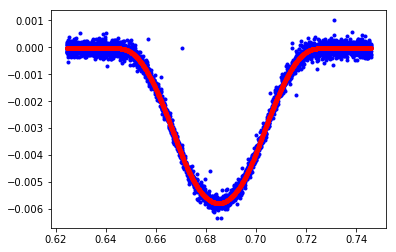

In [10]:
# Adjust fit parameters using new period
def fit_transit_with_new_period(time, baseline, a, T0, p, b, supersample_factor=10, exp_time=30./60./24.):
    params = K76.saved_params.copy()

    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = a
    ma['T0'] = T0
    ma['p'] = p
    ma['i'] = np.arccos(b/a)*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

# Fit folded transit
bounds = ([-1000e-6, 2., K76.saved_params['T0']*0.95, 0., -1],
          [1000e-6, 10., K76.saved_params['T0']*1.05, 0.2, 1])

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., K76.saved_params['a'], K76.saved_params['T0'], K76.saved_params['p'], K76.saved_params['b']]
new_transit_popt, new_transit_pcov = curve_fit(fit_transit_with_new_period, time, data, sigma=err, 
                                       p0=initial_guess, bounds=bounds)

new_transit_uncertainties = np.sqrt(new_transit_pcov.diagonal())

print(transit_popt)
print(transit_uncertainties)
print(new_transit_popt)
print(new_transit_uncertainties)

plt.plot(time, data, 'b.')
plt.plot(time, fit_transit(time, *new_transit_popt), 'r.')

Ks_2sampResult(statistic=0.00136836343732899, pvalue=0.9999999999999997)


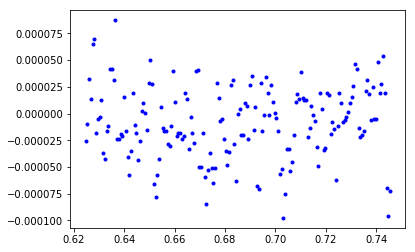

In [11]:
# 2018 Oct 19 - Checking residuals
second_resid = data - fit_transit(time, *new_transit_popt)

md = mad(second_resid)

hst, bin_edges = np.histogram(second_resid, bins='auto')
# plt.plot(bin_edges[:-1], hst)
# plt.axvline(np.median(resid))
# plt.xlim([-10*md, 10.*md])

binned_time, binned_resid, binned_err = bindata(time, second_resid, 1./60./24.)
plt.plot(binned_time, binned_resid, 'b.')

print(ks_2samp(first_resid, second_resid))

In [12]:
new_dur = transit_duration({'per': ephemeris_popt[0], 'p': new_transit_popt[3], 'b': new_transit_popt[4], 
                            'a': new_transit_popt[1]})

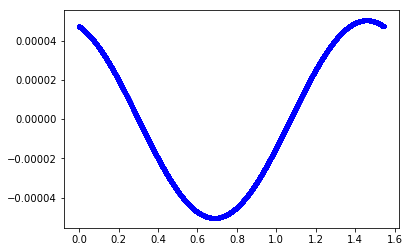

In [13]:
def fit_eclipse_and_BEER_signals(time, baseline, eclipse_depth, Aellip, Abeam, Aplanet, phase_shift,
                        transit_params=new_transit_popt, supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = transit_params[1]
    ma['T0'] = (ephemeris_popt[1] % ephemeris_popt[0]) + 0.5*params['per']
    ma['p'] = np.sqrt(np.abs(eclipse_depth))*np.sign(eclipse_depth)
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = 0.
    ma["quadLimb"] = 0.
    
#    transit_supersample = np.zeros_like(time_supersample)
    transit_supersample = ma.evaluate(time_supersample) - 1.
    
#     BEER_signals = np.zeros_like(time_supersample)
    params['per'] = ephemeris_popt[0]
    params['baseline'] = 0.
    params['Aellip'] = Aellip
    params['Abeam'] = Abeam
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift
    params['a'] = transit_params[1]
    params['T0'] = (ephemeris_popt[1] % ephemeris_popt[0])
    params['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    
    cur_BC = BEER_curve(time_supersample, params, supersample_factor=1)
    BEER_signals = cur_BC.all_signals()
    
    signal = BEER_signals + transit_supersample + baseline
    
    return np.mean(signal.reshape(-1, supersample_factor), axis=1)

initial_guess = [0., 0., 0., 0., 
                 K76.saved_params['Aplanet'], 0.]
plt.plot(folded_time, fit_eclipse_and_BEER_signals(folded_time, *initial_guess), 'b.')

In [14]:
# 2018 Oct 15 - Fit folded BEER and eclipse
out_of_transit_ind = ~transit_indices(folded_time, 3.*new_dur, (ephemeris_popt[1] % ephemeris_popt[0]))
unfolded_time = filtered_time[out_of_transit_ind]
time = folded_time[out_of_transit_ind]
data = filtered_flux[out_of_transit_ind]
err = unbinned_noise*np.ones_like(time)

bounds = ([-1000e-6, -1000e-6, -500e-6, -500e-6, -500e-6, -1], 
          [1000e-6, 1000e-6, 500e-6, 500e-6, 500e-6, 1])
initial_guess = [0., 100e-6, K76.saved_params['Aellip'], K76.saved_params['Abeam'], 
                 K76.saved_params['Aplanet'], 0.]

new_BEER_popt, new_BEER_pcov = curve_fit(fit_eclipse_and_BEER_signals, time, data, sigma=err, 
                       p0=initial_guess, bounds=bounds)
new_BEER_uncertainties = np.sqrt(new_BEER_pcov.diagonal())

# Rescale uncertainties
redchisq = redchisqg(data, fit_eclipse_and_BEER_signals(time, *new_BEER_popt), 2, err)
new_BEER_uncertainties *= np.sqrt(redchisq)

print(new_BEER_popt)
print(new_BEER_uncertainties)

[2.68837643e-05 8.66138711e-05 1.21249797e-05 1.20744254e-05
 4.98308625e-05 2.76281908e-03]
[8.26686933e-07 5.42792576e-06 1.26301751e-06 1.03510293e-06
 1.26007407e-06 3.24360062e-10]


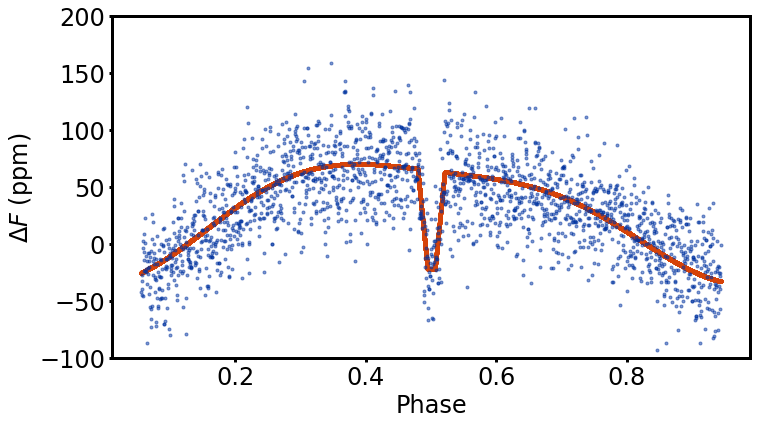

In [16]:
binned_time, binned_data, binned_err = bindata((unfolded_time - ephemeris_popt[1]) % ephemeris_popt[0], 
                                               data, 1./60./24.)

fig = plt.figure(figsize=(6.*16/9, 6))
ax = fig.add_subplot(111)

ephemeris_popt[1] % ephemeris_popt[0]
ax.plot(((unfolded_time - ephemeris_popt[1]) % ephemeris_popt[0])/ephemeris_popt[0], 
        fit_eclipse_and_BEER_signals(time, *new_BEER_popt)*1e6, BoiseState_orange, marker='.', ls='')
ax.plot(binned_time/ephemeris_popt[0], binned_data*1e6, BoiseState_blue, marker='.', ls='', alpha=0.5)

ax.tick_params(labelsize=24, width=3)
ax.set_ylim([-100, 200])

ax.set_xlabel('Phase', fontsize=24)
ax.set_ylabel('$\\Delta F$ (ppm)', fontsize=24)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.tight_layout()
#fig.savefig('all-folded-data-BEER-signal_Analyzing_Kepler76b_with_LM.png', dpi=500)

NormaltestResult(statistic=228.0074756894233, pvalue=3.0818091317722274e-50)


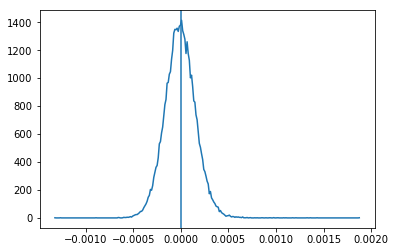

In [17]:
# 2018 Oct 19 - Checking residuals
third_resid = data - fit_eclipse_and_BEER_signals(time, *new_BEER_popt)

med = np.median(third_resid)
md = mad(third_resid)

hst, bin_edges = np.histogram(third_resid, bins='auto')
plt.plot(bin_edges[:-1], hst)
plt.axvline(np.median(third_resid))
#plt.xlim([-10*md, 10.*md])

ind = np.abs(third_resid - med) < 5.*md
print(normaltest(third_resid[ind]))

#binned_time, binned_resid, binned_err = bindata(time, resid, 1./60./24.)
#plt.plot(binned_time, binned_resid, 'b.')

In [18]:
# Fitting eclipses and BEER signals together
def fit_eclipse_and_BEER_signals_fixed_beam(time, baseline, eclipse_depth, Aellip, Aplanet, phase_shift,
                                                  BEER_params=new_BEER_popt, transit_params=new_transit_popt, 
                                                  supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = transit_params[1]
    ma['T0'] = (ephemeris_popt[1] % ephemeris_popt[0]) + 0.5*params['per']
    ma['p'] = np.sqrt(np.abs(eclipse_depth))*np.sign(eclipse_depth)
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = 0.
    ma["quadLimb"] = 0.
    
#    transit_supersample = np.zeros_like(time_supersample)
    transit_supersample = ma.evaluate(time_supersample) - 1.
    
#     BEER_signals = np.zeros_like(time_supersample)
    params['per'] = ephemeris_popt[0]
    params['baseline'] = 0.
    params['Aellip'] = Aellip
    params['Abeam'] = BEER_params[3]
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift
    params['a'] = transit_params[1]
    params['T0'] = (ephemeris_popt[1] % ephemeris_popt[0])
    params['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    
    cur_BC = BEER_curve(time_supersample, params, supersample_factor=1)
    BEER_signals = cur_BC.all_signals()
    
    signal = BEER_signals + transit_supersample + baseline
    
    return np.mean(signal.reshape(-1, supersample_factor), axis=1)

def fit_eclipse_and_BEER_signals_fixed_beam_ellip(time, baseline, eclipse_depth, Aplanet, phase_shift,
                                                  BEER_params=new_BEER_popt, transit_params=new_transit_popt, 
                                                  supersample_factor=10, exp_time=30./60./24.):
    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    params = K76.saved_params.copy()
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = ephemeris_popt[0]
    ma['a'] = transit_params[1]
    ma['T0'] = (ephemeris_popt[1] % ephemeris_popt[0]) + 0.5*params['per']
    ma['p'] = np.sqrt(np.abs(eclipse_depth))*np.sign(eclipse_depth)
    ma['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    ma["linLimb"] = 0.
    ma["quadLimb"] = 0.
    
#    transit_supersample = np.zeros_like(time_supersample)
    transit_supersample = ma.evaluate(time_supersample) - 1.
    
#     BEER_signals = np.zeros_like(time_supersample)
    params['per'] = ephemeris_popt[0]
    params['baseline'] = 0.
    params['Aellip'] = BEER_params[2]
    params['Abeam'] = BEER_params[3]
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift
    params['a'] = transit_params[1]
    params['T0'] = (ephemeris_popt[1] % ephemeris_popt[0])
    params['i'] = np.arccos(transit_params[4]/transit_params[1])*180./np.pi
    
    cur_BC = BEER_curve(time_supersample, params, supersample_factor=1)
    BEER_signals = cur_BC.all_signals()
    
    signal = BEER_signals + transit_supersample + baseline
    
    return np.mean(signal.reshape(-1, supersample_factor), axis=1)

In [19]:
#baseline, eclipse_depth, Aellip, Abeam, Aplanet, phase_shift

# fig = plt.figure(figsize=(10,10))

num_periods_to_fold = 20.

orbit_times = {}
best_fit_params = {}
best_fit_params_uncertainties = {}

orbit_times[num_periods_to_fold] = [0.]

bounds = ([-1000e-6, -1000e-6, -500e-6, -1], 
          [1000e-6, 1000e-6, 500e-6, 1])
initial_guess = [0., 100e-6, K76.saved_params['Aplanet'], 0.]
best_fit_params[num_periods_to_fold] = initial_guess
best_fit_params_uncertainties[num_periods_to_fold] = initial_guess

mn = np.min(filtered_time)
mx = np.min(filtered_time) + num_periods_to_fold*ephemeris_popt[0]

resid = []

while(mx <= np.max(filtered_time) - num_periods_to_fold*ephemeris_popt[0]):
# while(mn <= np.min(filtered_time) + ephemeris_popt[0]):
    
    # Next orbit's data, minus the transit portion    
    ind = ((filtered_time >= mn) & (filtered_time < mx))
    unfolded_time = filtered_time[ind]
    time = folded_time[ind]
    data = filtered_flux[ind]
    err = unbinned_noise*np.ones_like(time)
    
    out_of_transit_ind = ~transit_indices(time, 3.*K76.dur, (ephemeris_popt[1] % ephemeris_popt[0]))
    unfolded_time = unfolded_time[out_of_transit_ind]
    time = time[out_of_transit_ind]
    data = data[out_of_transit_ind]
    err = err[out_of_transit_ind]
    
    if(time.size >= np.floor(num_periods_to_fold/2*ephemeris_popt[0]/(30./60./24.))):
    # 2018 Oct 16 - The gaps in the time series seem to coincide with jumps in the signals - Not good!
    #   To try to reduce the effect of the gaps, I'm going to require that the window NOT extend 
    #   into a gap.
    
#     del_time = 0.
#     if(time.size > 0):
#         del_time = (np.max(unfolded_time) - np.min(unfolded_time))
#     if(np.abs(del_time - num_periods_to_fold*ephemeris_popt[0]) <= 5.*(30./60./24.)):

        cur_orbit_time = np.mean(unfolded_time)
        popt, pcov = curve_fit(fit_eclipse_and_BEER_signals_fixed_beam_ellip, time, data, sigma=err, 
                               p0=initial_guess, bounds=bounds)
        uncertainties = np.sqrt(pcov.diagonal())

        # Rescale uncertainties
        redchisq = redchisqg(data, fit_eclipse_and_BEER_signals_fixed_beam_ellip(time, *popt), 2, err)

        orbit_times[num_periods_to_fold] =\
            np.append(orbit_times[num_periods_to_fold], cur_orbit_time)
        best_fit_params[num_periods_to_fold] = np.vstack((best_fit_params[num_periods_to_fold], popt))
        best_fit_params_uncertainties[num_periods_to_fold] =\
            np.vstack((best_fit_params_uncertainties[num_periods_to_fold], 
                      uncertainties*np.sqrt(redchisq)))
        
        resid.append(np.array(data - fit_eclipse_and_BEER_signals_fixed_beam_ellip(time, *popt)))
#         if(popt[1]/uncertainties[1] > 6.):
#         if((popt[1] > 150e-6) & (popt[1]/uncertainties[1] > 3.)):
#         if(popt[1] > 150e-6):
#        if(cur_orbit_time == 258.2398182173381):
#             fig = plt.figure()
            
#             binned_time, binned_data, binned_err = bindata(time, data, 15./60./24.)
#             plt.plot(time, fit_eclipse_and_BEER_signals_fixed_beam(time, *popt)*1e6, 'r.')
#             plt.plot(binned_time, binned_data*1e6, 'k.')
            
#             print(redchisq)
#             print(popt[1], uncertainties[1], popt[1]/uncertainties[1])
#             break
            
    mn += ephemeris_popt[0]
    mx += ephemeris_popt[0]
  
    # baseline, eclipse_depth, Aellip, Aplanet, phase_shift

#which_param = 1
# x = orbit_times[10][1:]
# y = best_fit_params[10][1:,which_param]
# yerr = best_fit_params_uncertainties[10][1:,which_param]
# ind = (np.abs(y/yerr) > 0.)
# # plt.errorbar(x[ind], y[ind]*1e6, yerr[ind]*1e6, marker='.', ls='')
# plt.plot(x[ind], (y[ind] - np.mean(y[ind]))/yerr[ind], marker='.', ls='')
    
# which_param = 3
# x = orbit_times[10][1:]
# y = best_fit_params[10][1:,which_param]
# yerr = best_fit_params_uncertainties[10][1:,which_param]
# ind = (np.abs(y/yerr) > 5)

# med_ind = (y == np.median(y))
# plt.plot(x[ind], (y[ind] - np.median(y))/np.sqrt(yerr[ind]**2 + yerr[med_ind]**2.), marker='.', ls='')
# print(np.max(np.abs((y[ind] - np.median(y))/np.sqrt(yerr[ind]**2 + yerr[med_ind]**2.))))

#plt.plot(best_fit_params[20][1:,1][ind]*1e6, best_fit_params[20][1:,3][ind]*1e6, marker='.', ls='')

#plt.plot(best_fit_params[20][1:,3][ind], best_fit_params[20][1:,4][ind], marker='.', ls='')

# plt.title('(eclipse depths - median(depth))/uncertainties')
# plt.xlabel('time (days)')
# plt.ylabel('variation in eclipse depth')
# fig.savefig('Analyzing_Kepler76b_with_LM_eclipse-depth-vars_20-orbs.png', dpi=500, bbox_inches='tight')

# plt.xlabel('time (days)', fontsize=24)
# plt.ylabel('$\\Delta F$ (ppm)', fontsize=24)
# plt.tick_params(labelsize=24)
# fig.savefig('Analyzing_Kepler76b_with_LM_171ppm-eclipse.png', dpi=500, bbox_inches='tight')

(1108.811727342756, 0.9975744208093736)
(555, 140)


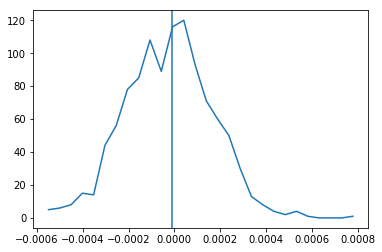

In [21]:
p_vals = np.zeros(len(resid))

for i in range(len(resid)):
    ind = np.abs(resid[i] - med) < 5.*md
    stat, p = normaltest(resid[i][ind])
    p_vals[i] = p
    
print(orbit_times[num_periods_to_fold][np.argmax(p_vals)], np.max(p_vals))
hst, bin_edges = np.histogram(resid[np.argmax(p_vals)], bins='auto')
plt.plot(bin_edges[:-1], hst)
plt.axvline(np.median(resid[i]))

print(len(p_vals[p_vals >= 1e-3]), len(p_vals[p_vals < 1e-3]))

(9.8989796075312e-06, 0.00016170699189686823)


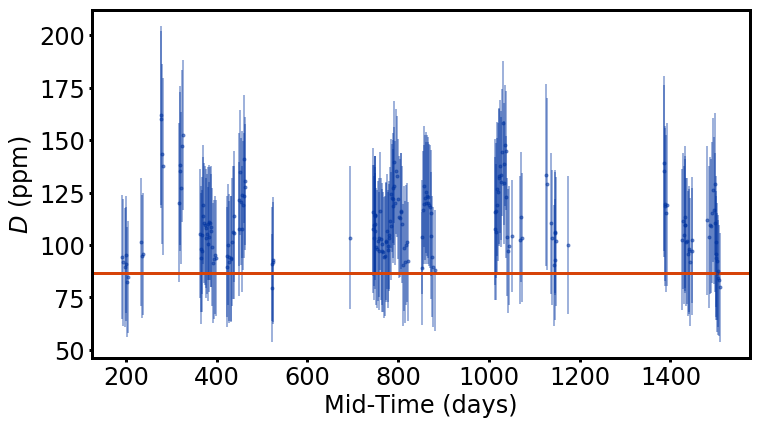

In [24]:
which_param = 1

x = orbit_times[num_periods_to_fold][1:]
y = best_fit_params[num_periods_to_fold][1:,which_param]
print(np.min(y), np.max(y))
yerr = best_fit_params_uncertainties[num_periods_to_fold][1:,which_param]
ind = (np.abs(y/yerr) > 3) & (p_vals >= 1e-3)
# ind = (np.abs(1./yerr) > 5) & (p_vals >= 1e-3)

#baseline, eclipse_depth, Aplanet, phase_shift
#baseline, eclipse_depth, Aellip, Abeam, Aplanet, phase_shift

fig = plt.figure(figsize=(6*16./9, 6))
ax = fig.add_subplot(111)

ax.axhline(new_BEER_popt[1]*1e6, color=BoiseState_orange, lw=3)
ax.errorbar(x[ind], y[ind]*1e6, yerr[ind]*1e6, marker='.', ls='', color=BoiseState_blue, alpha=0.5)

ax.tick_params(labelsize=24, width=3)

ax.set_xlabel('Mid-Time (days)', fontsize=24)
ax.set_ylabel('$D$ (ppm)', fontsize=24)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.tight_layout()
#fig.savefig('eclipse-variability_20-orbs_Analyzing_Kepler76b_with_LM.png', dpi=500)

[ 0.11256623 66.6113144 ]
[0.015807   1.45902224]
[ 7.12128911 45.65476301]


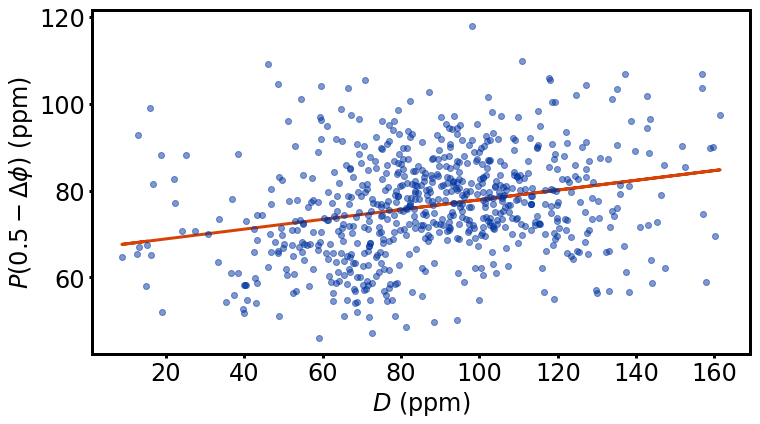

In [169]:
baseline = best_fit_params[num_periods_to_fold][1:,0]

x = best_fit_params[num_periods_to_fold][1:,1]
xerr = best_fit_params_uncertainties[num_periods_to_fold][1:,1]

y = best_fit_params[num_periods_to_fold][1:,2]
yerr = best_fit_params_uncertainties[num_periods_to_fold][1:,2]

ph_sh = best_fit_params[num_periods_to_fold][1:,3]

ind = (np.abs(x/xerr) > 0) & (np.abs(y/yerr) > 0)

p, cov = np.polyfit(x[ind]*1e6, (baseline[ind] - y[ind]*np.cos(2*np.pi*(0.5 - ph_sh[ind])))*1e6, 1, cov=True)
print(p)
print(np.sqrt(cov.diagonal()))
print(p/np.sqrt(cov.diagonal()))

fig = plt.figure(figsize=(6*16./9, 6))
ax = fig.add_subplot(111)

ax.plot(x[ind]*1e6, np.polyval(p, x[ind]*1e6), color=BoiseState_orange, lw=3)
ax.plot(x[ind]*1e6, (baseline[ind] - y[ind]*np.cos(2*np.pi*(0.5 - ph_sh[ind])))*1e6, 
         marker='o', ls='', color=BoiseState_blue, alpha=0.5)
ax.tick_params(labelsize=24, width=3)

ax.set_xlabel('$D$ (ppm)', fontsize=24)
ax.set_ylabel("$P\\left( 0.5 - \Delta \phi \\right)$ (ppm)", fontsize=24)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.tight_layout()
fig.savefig('phase-curve_vs_ecl-var_20-orbs_Analyzing_Kepler76b_with_LM.png', dpi=500)

In [76]:
x = orbit_times[10][1:]
y = best_fit_params[10][1:, 1]
yerr = best_fit_params_uncertainties[10][1:,1]
# ind = (np.abs(1./yerr) > 3) & (x/xerr > 3) & (p_vals >= 1e-3)
ind = (np.abs(y/yerr) > 3)# & (p_vals >= 1e-3)

# plt.errorbar(x[ind]*1e6, y[ind], xerr=xerr[ind]*1e6, yerr=yerr[ind], marker='.', ls='')

fig = plt.figure(figsize=(10, 10))

plt.errorbar(x[ind], y[ind]*1e6, yerr[ind]*1e6, marker='o', ls='')
plt.xlabel('time (days)', fontsize=24)
plt.ylabel('eclipse depth (ppm)', fontsize=24)
plt.tick_params(labelsize=24)
fig.savefig('Analyzing_Kepler76b_with_LM_eclipse-depths.png', dpi=500, bbox_inches='tight')

# p, cov = np.polyfit(x[ind]*1e6, y[ind], 1, cov=True)
# print(p)
# print(np.sqrt(cov.diagonal()))

KeyError: 10

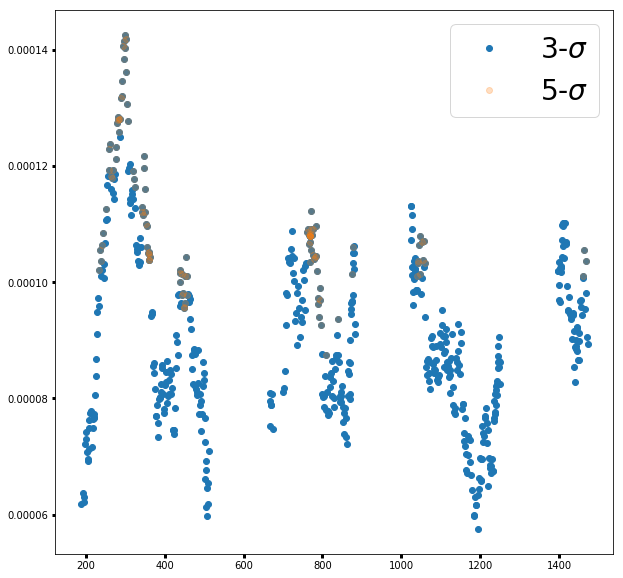

In [176]:
fig = plt.figure(figsize=(10,10))

num_periods_to_fold = 50

ind = (best_fit_params[num_periods_to_fold][1:,1]/best_fit_params_uncertainties[num_periods_to_fold][1:,1] > 3.)
x = orbit_times[num_periods_to_fold][1:]
y = best_fit_params[num_periods_to_fold][1:,1]
yerr = best_fit_params_uncertainties[num_periods_to_fold][1:,1]
plt.plot(x[ind], y[ind], marker='o', ls='', label="3-$\\sigma$")
#plt.errorbar(x[ind], y[ind]*1e6, yerr[ind]*1e6, color='k', marker='.', ls='')

ind = (best_fit_params[num_periods_to_fold][1:,1]/best_fit_params_uncertainties[num_periods_to_fold][1:,1] > 5.)
x = orbit_times[num_periods_to_fold][1:]
y = best_fit_params[num_periods_to_fold][1:,1]
yerr = best_fit_params_uncertainties[num_periods_to_fold][1:,1]
plt.plot(x[ind], y[ind], marker='o', ls='', alpha=0.25, label="5-$\\sigma$")
#plt.errorbar(x[ind], y[ind]*1e6, yerr[ind]*1e6, marker='.', ls='', alpha=0.5)

plt.legend(fontsize=28)
fig.savefig('Eclipse-Variability_stacking-50-orbs.png', dpi=500, bbox_inches='tight')

46


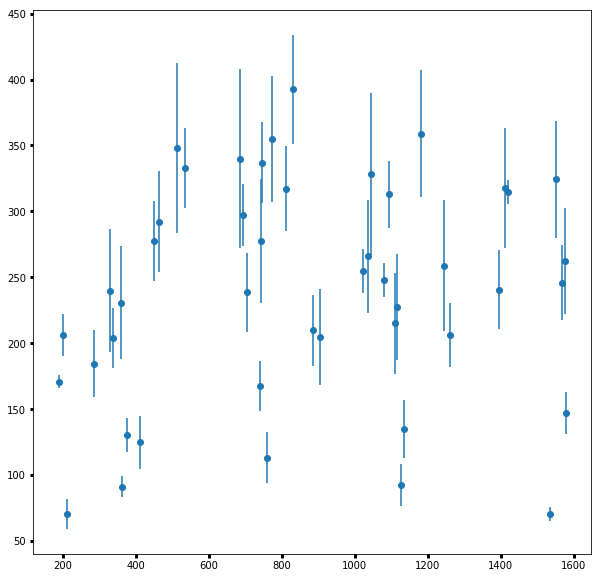

In [86]:
plt.figure(figsize=(10,10))

for cur_key in [1]:
    ind = eclipse_depths[cur_key]/eclipse_depths_uncertainties[cur_key] > 5.
    med = np.median(eclipse_depths[cur_key][ind])
    plt.errorbar(eclipse_times[cur_key][ind], eclipse_depths[cur_key][ind]*1e6, 
                 eclipse_depths_uncertainties[cur_key][ind]*1e6, marker='o', ls='')
#    plt.plot(eclipse_times[cur_key][ind], eclipse_depths[cur_key][ind])
    
    print(eclipse_times[cur_key][ind].size)
    
#dill.dump_session("Analyzing_Kepler76b_with_LM_2018Oct11_5-06p.pkl")

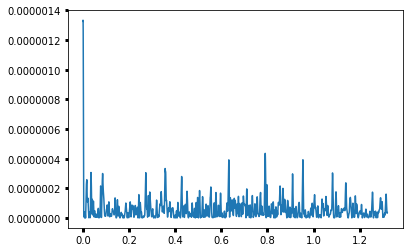

In [74]:
# And finally check for any periodic signals -
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html

cur_key = 1.
ind = eclipse_depths[cur_key]/eclipse_depths_uncertainties[cur_key] > 5.

nout = 10000
max_freq = 2./np.min(eclipse_times[1][ind][1:] - eclipse_times[1][ind][0:-1])
min_freq = 1./(np.max(eclipse_times[1][ind]) - np.min(eclipse_times[1][ind][0:-1]))
f = np.linspace(min_freq, max_freq, nout)
pgram = lombscargle(eclipse_times[1][ind], eclipse_depths[cur_key][ind], f)
# No peak (except for peak for whole time span) is more than barely above the other peaks, suggesting no periodicity
plt.plot(f, pgram)

In [3]:
# 2018 Oct 12 - Reload previous results
dill.load_session("Analyzing_Kepler76b_with_LM_2018Oct11_5-06p.pkl")

TypeError: cannot create weak reference to 'NoneType' object

[ 2.79791262e-05  1.60345217e-05  7.08068469e-06  4.65910137e-05
 -1.53652806e-02]
[2.48885784e-04 3.84395223e-04 6.14045712e+04 5.91897389e+03
 2.08781299e+08]


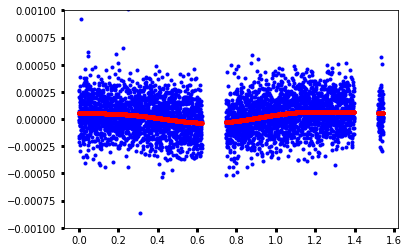

In [68]:
# Fit the planetary phase curves and check whether it is consistent with the eclipse depths

# fit_BEER_signals(cur_time, baseline, Aellip, Abeam, Aplanet, phase_shift)

bounds = ([-500e-6, -500e-6, -500e-6, -500e-6, -1],
          [500e-6, 500e-6, 500e-6, 500e-6, 1])
initial_guess = [0., K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['Aplanet'], 
                 K76.saved_params['phase_shift']]


out_of_transit_ind = ~(transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0']) | 
                       transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'] + 0.5*K76.saved_params['per']))

filtered_time_all_BEER = filtered_time[out_of_transit_ind]
folded_time_all_BEER = folded_time[out_of_transit_ind]
filtered_flux_all_BEER = filtered_flux[out_of_transit_ind]

num_periods_to_fold = 75.

mn = np.min(filtered_time)
mx = np.min(filtered_time) + num_periods_to_fold*ephemeris_popt[0]

orbit_times = {}
BEER_params = {}
BEER_params_uncertainties = {}

orbit_times[num_periods_to_fold] = np.array([])
BEER_params[num_periods_to_fold] = initial_guess
BEER_params_uncertainties[num_periods_to_fold] = initial_guess
#while(mx <= np.max(filtered_time_all_BEER) - num_periods_to_fold*K76.saved_params['per']):
while(mn < np.min(filtered_time) + 2.*K76.saved_params['per']):
    
    try:
        ind = (filtered_time_all_BEER >= mn) & (filtered_time_all_BEER < mx)
        time = folded_time_all_BEER[ind]
        data = filtered_flux_all_BEER[ind]
        err = unbinned_noise*np.ones_like(time)
        
        BEER_popt, BEER_pcov = curve_fit(fit_BEER_signals, time, data, sigma=err, 
                                         p0=initial_guess, bounds=bounds)
        BEER_uncertainties = np.sqrt(BEER_pcov.diagonal())

        # Rescale uncertainties
        redchisq = redchisqg(data, fit_BEER_signals(time, *BEER_popt), 5, err)
        print(BEER_popt)
        print(BEER_uncertainties)
        
        # If chi-squared is weird...
        if((~np.isfinite(redchisq)) | (redchisq < 0.) | (np.isnan(redchisq))):
            pass
        
        orbit_times[num_periods_to_fold] =\
            np.append(orbit_times[num_periods_to_fold], np.mean(filtered_time_all_BEER[ind]))
        BEER_params[num_periods_to_fold] = np.vstack((BEER_params[num_periods_to_fold], BEER_popt))
        BEER_params_uncertainties[num_periods_to_fold] =\
            np.vstack((BEER_params_uncertainties[num_periods_to_fold], BEER_uncertainties*np.sqrt(redchisq)))

        plt.plot(folded_time_all_BEER[ind], filtered_flux_all_BEER[ind], 'b.')
        plt.plot(folded_time_all_BEER[ind], fit_BEER_signals(folded_time_all_BEER[ind], *BEER_popt), 'r.')
        plt.ylim([-0.001, 0.001])
        break

    except:
        pass
    
    mn += K76.saved_params['per']
    mx += K76.saved_params['per']

#print(BEER_params_uncertainties[num_periods_to_fold][1:,:])

# Aplanet = BEER_params[num_periods_to_fold][1:,3]
# Aplanet_err = BEER_params_uncertainties[num_periods_to_fold][1:,:]
# ind = (~np.isnan(Aplanet_err))
# print(Aplanet_err[ind])

# plt.plot(orbit_times[num_periods_to_fold][ind], Aplanet[ind], 'b.')